In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:

def create_frequency_grid(size):
    """Create a 2D frequency grid centered at (size//2, size//2)."""
    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    X, Y = np.meshgrid(x, y)
    D = np.sqrt(X**2 + Y**2)
    return D, X, Y

def create_1d_profile(size):
    """Create 1D frequency profile."""
    return np.linspace(0, size//2, size//2)

def ideal_highpass(D, D0):
    """Ideal highpass filter response."""
    return (D > D0).astype(float)

def butterworth_highpass(D, D0, n):
    """Butterworth highpass filter response."""
    return 1 / (1 + (D0 / D)**(2 * n))

def gaussian_highpass(D, D0):
    """Gaussian highpass filter response."""
    return 1 - np.exp(-(D**2) / (2 * D0**2))

def plot_comprehensive_view(D0, n_butterworth, filter_type='All'):
    """Create comprehensive visualization with 1D, 3D and magnitude plots."""
    # Create frequency grids
    size = 100
    D_2d, X, Y = create_frequency_grid(size)
    D_1d = create_1d_profile(size)

    # Calculate filter responses
    filters = {}
    if filter_type in ['All', 'Ideal']:
        filters['Ideal'] = ideal_highpass(D_2d, D0)
    if filter_type in ['All', 'Butterworth']:
        filters['Butterworth'] = butterworth_highpass(D_2d, D0, n_butterworth)
    if filter_type in ['All', 'Gaussian']:
        filters['Gaussian'] = gaussian_highpass(D_2d, D0)

    # Create subplots
    n_filters = len(filters)
    fig = plt.figure(figsize=(5*n_filters, 12))

    # Plot for each filter
    for idx, (name, response) in enumerate(filters.items()):
        # Handle division by zero at D=0 for display
        response = np.nan_to_num(response, nan=0.0, posinf=1.0, neginf=0.0)

        # 1D Profile
        ax1 = fig.add_subplot(3, n_filters, idx + 1)
        ax1.plot(D_1d, response[size//2, size//2:], linewidth=2)
        ax1.set_title(f'{name} Highpass Filter 1D Profile')
        ax1.set_xlabel('Frequency')
        ax1.set_ylabel('Response')
        ax1.grid(True)

        # 3D Surface
        ax2 = fig.add_subplot(3, n_filters, idx + 1 + n_filters, projection='3d')
        surf = ax2.plot_surface(X, Y, response, cmap='viridis')
        ax2.set_title(f'{name} Highpass Filter 3D Surface')
        ax2.set_xlabel('u')
        ax2.set_ylabel('v')
        ax2.set_zlabel('H(u,v)')

        # Magnitude Image
        ax3 = fig.add_subplot(3, n_filters, idx + 1 + 2*n_filters)
        im = ax3.imshow(response, cmap='viridis')
        ax3.set_title(f'{name} Highpass Filter Magnitude')
        plt.colorbar(im, ax=ax3)

    plt.tight_layout()
    plt.show()

def apply_filter_to_array(img, D0=30, n_butterworth=2):
    """Apply all highpass filters to a numpy array image."""
    if len(img.shape) > 2:
        img = np.mean(img, axis=2)  # Convert to grayscale

    # Get centered FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)

    # Create frequency grid
    rows, cols = img.shape
    D, _, _ = create_frequency_grid(rows)

    # Create filters
    filters = {
        'Ideal': ideal_highpass(D, D0),
        'Butterworth': butterworth_highpass(D, D0, n_butterworth),
        'Gaussian': gaussian_highpass(D, D0)
    }

    # Apply filters
    filtered_images = {}
    filtered_spectrums = {}
    for name, filt in filters.items():
        filtered_shift = fshift * filt
        filtered_images[name] = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_shift)))
        filtered_spectrums[name] = np.log(np.abs(filtered_shift) + 1)

    # Plot results
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Original image and spectrum
    axes[0,0].imshow(img, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[1,0].imshow(magnitude_spectrum, cmap='gray')
    axes[1,0].set_title('Original Spectrum')

    # Filtered images and spectrums
    for idx, (name, filtered) in enumerate(filtered_images.items(), 1):
        axes[0,idx].imshow(filtered_images[name], cmap='gray')
        axes[0,idx].set_title(f'{name} Highpass Filtered')
        axes[1,idx].imshow(filtered_spectrums[name], cmap='gray')
        axes[1,idx].set_title(f'{name} Spectrum')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def create_test_images(size=256):
    """Create multiple test images with pronounced edges."""
    # 1. Checkerboard pattern
    checkerboard = np.zeros((size, size))
    tile_size = size // 16
    for i in range(size):
        for j in range(size):
            if ((i // tile_size) + (j // tile_size)) % 2 == 0:
                checkerboard[i, j] = 1

    # 2. Geometric shapes
    shapes = np.zeros((size, size))
    # Add rectangle
    shapes[size//4:3*size//4, size//4:3*size//4] = 1
    # Add circle
    center = size // 2
    radius = size // 6
    y, x = np.ogrid[-center:size-center, -center:size-center]
    mask = x*x + y*y <= radius*radius
    shapes[mask] = 0.5
    # Add diagonal line
    np.fill_diagonal(shapes, 1)

    # 3. Text-like pattern (E letter)
    text = np.zeros((size, size))
    # Vertical line
    text[size//4:3*size//4, size//4:(size//4 + size//20)] = 1
    # Horizontal lines
    text[size//4:(size//4 + size//20), size//4:2*size//3] = 1  # Top
    text[size//2:(size//2 + size//20), size//4:2*size//3] = 1  # Middle
    text[3*size//4:(3*size//4 + size//20), size//4:2*size//3] = 1  # Bottom

    return {
        'Checkerboard': checkerboard,
        'Geometric': shapes,
        'Text': text
    }

def apply_filter_to_array(img, D0=30, n_butterworth=2):
    """Apply all highpass filters to a numpy array image."""
    if len(img.shape) > 2:
        img = np.mean(img, axis=2)  # Convert to grayscale

    # Get centered FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)

    # Create frequency grid
    rows, cols = img.shape
    D, _, _ = create_frequency_grid(rows)

    # Create filters
    filters = {
        'Ideal': ideal_highpass(D, D0),
        'Butterworth': butterworth_highpass(D, D0, n_butterworth),
        'Gaussian': gaussian_highpass(D, D0)
    }

    # Apply filters
    filtered_images = {}
    filtered_spectrums = {}
    for name, filt in filters.items():
        filtered_shift = fshift * filt
        filtered_images[name] = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_shift)))
        filtered_spectrums[name] = np.log(np.abs(filtered_shift) + 1)

    # Plot results
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Original image and spectrum
    axes[0,0].imshow(img, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[1,0].imshow(magnitude_spectrum, cmap='gray')
    axes[1,0].set_title('Original Spectrum')

    # Filtered images and spectrums
    for idx, (name, filtered) in enumerate(filtered_images.items(), 1):
        axes[0,idx].imshow(filtered_images[name], cmap='gray')
        axes[0,idx].set_title(f'{name} Highpass Filtered')
        axes[1,idx].imshow(filtered_spectrums[name], cmap='gray')
        axes[1,idx].set_title(f'{name} Spectrum')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show filter responses
interact(
    plot_comprehensive_view,
    D0=widgets.IntSlider(
        value=20,
        min=1,
        max=50,
        step=1,
        description='D₀:',
        continuous_update=False
    ),
    n_butterworth=widgets.IntSlider(
        value=2,
        min=1,
        max=10,
        step=1,
        description='n:',
        continuous_update=False
    ),
    filter_type=widgets.Dropdown(
        options=['All', 'Ideal', 'Butterworth', 'Gaussian'],
        description='Filter:',
        value='All'
    )
)

interactive(children=(IntSlider(value=20, continuous_update=False, description='D₀:', max=50, min=1), IntSlide…

<function __main__.plot_comprehensive_view(D0, n_butterworth, filter_type='All')>

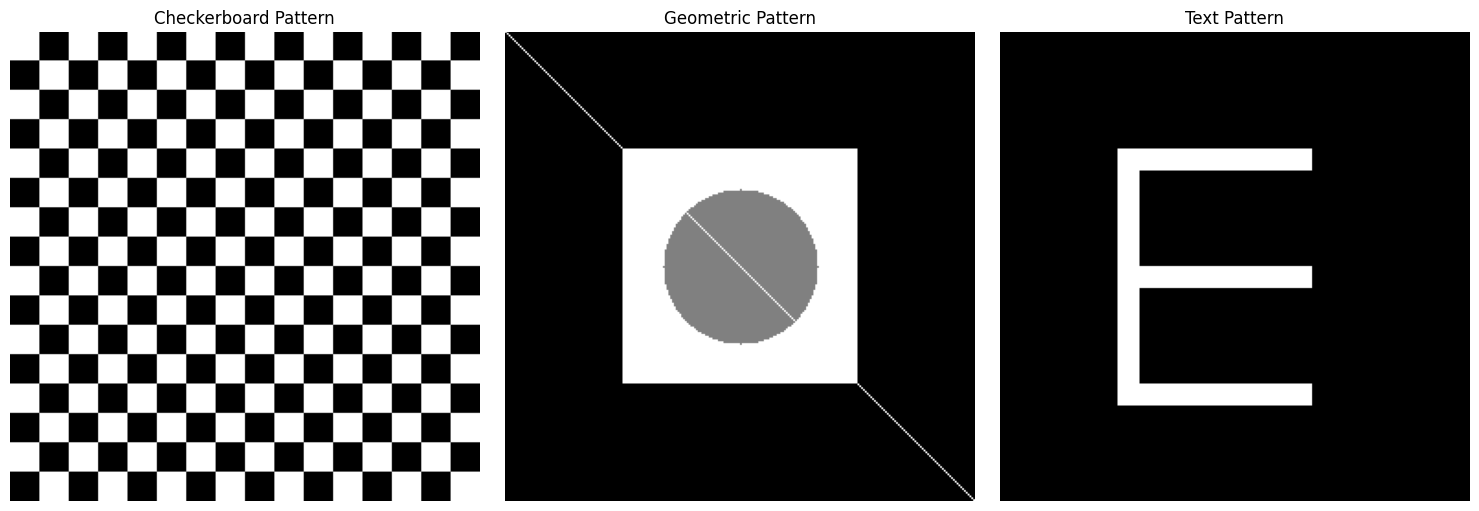

In [3]:
# Generate test images
test_images = create_test_images(256)

# Display all test images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (name, img) in enumerate(test_images.items()):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'{name} Pattern')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()



In [4]:
# Create widget for image selection and filtering
image_dropdown = widgets.Dropdown(
    options=test_images.keys(),
    description='Image:',
    value='Checkerboard'
)

# Interactive filtering with image selection
@interact
def interactive_filtering(
    image=image_dropdown,
    D0=widgets.IntSlider(
        value=30,
        min=1,
        max=100,
        step=1,
        description='D₀:',
        continuous_update=False
    ),
    n_butterworth=widgets.IntSlider(
        value=2,
        min=1,
        max=10,
        step=1,
        description='n:',
        continuous_update=False
    )
):
    apply_filter_to_array(test_images[image], D0, n_butterworth)



interactive(children=(Dropdown(description='Image:', options=('Checkerboard', 'Geometric', 'Text'), value='Che…